# Assignment 1 - Simplified Custom Object Detection

This notebook contains the required task for the first assignment of the Deep Network Development course. Read the task description and fill in the empty code cells. Each section represents an implementation stage of object detection: -from `loading and inspecting the dataset`; -to `implementing`, `training and evaluating a Convolutional Neural Network based architecture`. The sections are there to guide you but you do not have to follow them strictly.

Copy this notebook to your drive (File -> Save a copy in Drive), edit it, and upload the final .ipynb file to [Canvas](https://canvas.elte.hu). If you are using this in Google Colab notebook, save it as .ipynb and upload it, or share the public link. If you have your own machine with Jupyter installed, you can work there as well, as long as you save and upload the .ipynb file.


## General Rules
Please check all the requirements listed on Canvas, but here are some general rules:
- Please select at least ANY 3 objects of choice. Try to pick unique objects. You may pick more, but less than 3 is not acceptable and results in losing points;
- While we do not require a high performance model, we still expect you to have a model that performs better than "random guessing" (i.e. for 3 objects, mAP should be better than 33%);
- Copying others' code will make you fail the assignment automatically, resulting in a 0;
- Not submitting anything results in a 0;
- Submitting something, as long as it is not an empty notebook, might result in a 1;
- **Deadline is October 25th Friday 11:59 PM** (strict, no late submission)
- Feel free to add more code cells as needed. But don't put code into external Python files.
- Please add your name, Neptun ID, and task details below.

**Name:** Marton Ligetfalvi
**Neptun ID:** GOEG01
**Network:** Custom Convolutional Neural Network
**Objects:** Car, Person, Dog

## Task description

**Your task** is to train your own custom object detection model and compare its performance with an existing object detection model (i.e., YOLO). For that, you need to generate a synthetic dataset to train your own custom model and fine-tune an existing one. This is a simplified version of object detection, where each image must only contain a single object.

- There is no expectation of high performance, but **your metrics should show results better than random guessing, and your loss must decrease throughout the epochs**.

- We expect you to visualize the key metrics such as precision, recall, F1-score, mAP (mean average precision), IoU (Intersection over Union), and localization loss, in addition to monitoring the overall loss and its reduction across training. Use plots and visualizations (e.g., matplotlib, seaborn) to display metrics, losses, and predictions.

- You should implement techniques to avoid overfitting, such as Early Stopping, and save the best-performing model during training.

- Additionally, you can use **WandB (Weights and Biases)** or **TensorBoard** to track and visualize training progress, monitor the model's performance, and log metrics over time.

`Good luck!`

**In order to get your grade for the assignment, you must defend it by answering questions during the designated practice time.**

## Guidelines
Please carefully read each cell of the notebook, as they contain guidelines to help you complete the assignments. While you don't have to follow them strictly, we believe that they provide enough help.

# 0. Necessary Imports
Import all the necessary packages for this assignment. **ONLY PYTORCH MODELS ARE ACCEPTED!**

In [1]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image  
from torchvision import models  
from sklearn.metrics import precision_score, recall_score, f1_score

# 1. DATASET
**For this assignment you are free to pick any 3 objects of your choice.** Please avoid offensive, inappropriate or violent objects.

### 1.1. Load objects

**Please select 3 or more objects.** After selecting the objects, **remove the background, keeping only the object itself**. You can do this manually, online, or by using code (this step is not part of the assignment evaluation).

As an example, the following objects were chosen (with the background removed using the Segment Anything Model):

In [4]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def collate_fn(batch):
    images, targets = list(zip(*batch)) 
    images = torch.stack([img for img in images], dim=0)
    return images, targets

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = datasets.VOCDetection(
    root="./data",
    year="2007",
    image_set="train",
    download=False,
    transform=transform
)

label_map = {"car": 1, "person": 2, "dog": 3}

def clip_boxes(boxes, epsilon=1e-3):
    return torch.clamp(boxes, min=epsilon, max=1.0 - epsilon)

def filter_dataset(dataset, desired_objects):
    filtered_data = []
    
    for img, target in dataset:
        objects_in_image = [obj['name'] for obj in target['annotation']['object']]
        
        if any(obj in desired_objects for obj in objects_in_image):
            filtered_annotations = {
                'boxes': [],
                'labels': []
            }
            
            for obj in target['annotation']['object']:
                if obj['name'] in desired_objects:
                    bbox = obj['bndbox']
                    xmin, ymin, xmax, ymax = int(bbox['xmin']), int(bbox['ymin']), int(bbox['xmax']), int(bbox['ymax'])
                    _, height, width = img.shape
                    
                    norm_bbox = [
                        xmin / width, ymin / height,
                        xmax / width, ymax / height
                    ]
                    
                    filtered_annotations['boxes'].append(norm_bbox)
                    filtered_annotations['labels'].append(label_map[obj['name']])
            
            if filtered_annotations['boxes']:
                filtered_annotations['boxes'] = torch.tensor(filtered_annotations['boxes'], dtype=torch.float32)
                filtered_annotations['boxes'] = clip_boxes(filtered_annotations['boxes'])
                filtered_annotations['labels'] = torch.tensor(filtered_annotations['labels'], dtype=torch.int64)
                
                filtered_data.append((img, filtered_annotations))
    
    return filtered_data

desired_objects = ["car", "person", "dog"]
filtered_dataset = filter_dataset(dataset, desired_objects)

dataloader = DataLoader(
    filtered_dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=collate_fn
)

for images, targets in dataloader:
    print(images.shape)
    print(targets)
    break


torch.Size([32, 3, 224, 224])
({'boxes': tensor([[0.9990, 0.3795, 0.9990, 0.7366],
        [0.3795, 0.1205, 0.9990, 0.9990]]), 'labels': tensor([1, 1])}, {'boxes': tensor([[0.6429, 0.7946, 0.7902, 0.9990],
        [0.7232, 0.9990, 0.9688, 0.9990],
        [0.9330, 0.9990, 0.9990, 0.9990],
        [0.9990, 0.9990, 0.9990, 0.9990],
        [0.9990, 0.9990, 0.9990, 0.9990]]), 'labels': tensor([2, 2, 2, 2, 2])}, {'boxes': tensor([[0.9990, 0.1920, 0.9990, 0.9990],
        [0.9990, 0.0848, 0.9990, 0.9990],
        [0.0536, 0.9990, 0.2277, 0.9990]]), 'labels': tensor([2, 2, 2])}, {'boxes': tensor([[0.9990, 0.5446, 0.9990, 0.9990],
        [0.0089, 0.0089, 0.9990, 0.9990],
        [0.9990, 0.0089, 0.9990, 0.5982],
        [0.9821, 0.2366, 0.9990, 0.7812]]), 'labels': tensor([2, 1, 1, 1])}, {'boxes': tensor([[0.5089, 0.2545, 0.9990, 0.9990],
        [0.9990, 0.0045, 0.9990, 0.4911],
        [0.5893, 0.0045, 0.9990, 0.4777]]), 'labels': tensor([3, 2, 2])}, {'boxes': tensor([[0.2232, 0.1562, 0.99

### 1.2. Load backgrounds

In order to train a custom object detection model, a dataset is needed. For this assignment, a synthetic dataset should be created by:

- **Inserting an object in a random position** on a background image.

**Therefore, collect a few background images from different locations** This can be done manually or via code.

It is recommended to use **icrawler** to automate the image collection process.


In [7]:
!pip install icrawler

In [5]:
!mkdir background

In case of any errors, try using a different crawler. You can use one of the following options:

```python
from icrawler.builtin import BaiduImageCrawler, BingImageCrawler, GoogleImageCrawler


In [6]:
from icrawler.builtin import GoogleImageCrawler

google_crawler = GoogleImageCrawler(
    parser_threads=2,
    downloader_threads=4,
    storage={'root_dir': 'background'}
)

for keyword in ['field', 'forest', 'mountain', 'desert', 'river']:
    google_crawler.crawl(
        keyword=keyword, max_num=10, file_idx_offset='auto')


2024-10-24 14:22:34,372 - INFO - icrawler.crawler - start crawling...
2024-10-24 14:22:34,372 - INFO - icrawler.crawler - starting 1 feeder threads...
2024-10-24 14:22:34,372 - INFO - feeder - thread feeder-001 exit
2024-10-24 14:22:34,405 - INFO - icrawler.crawler - starting 2 parser threads...
2024-10-24 14:22:34,410 - INFO - icrawler.crawler - starting 4 downloader threads...
2024-10-24 14:22:35,074 - INFO - parser - parsing result page https://www.google.com/search?q=field&ijn=0&start=0&tbs=&tbm=isch
2024-10-24 14:22:35,323 - INFO - downloader - image #1	https://static.vecteezy.com/system/resources/thumbnails/006/240/309/small_2x/nature-scenic-trees-and-green-meadow-field-rural-landscape-with-bright-cloudy-blue-sky-idyllic-adventure-landscape-natural-colorful-foliage-photo.jpg
2024-10-24 14:22:35,490 - ERROR - downloader - Response status code 404, file https://upload.wikimedia.org/wikipedia/commons/thumb/4/40/Field_in_K%C3%A4rk%C3%B6l%C3%A4.jpg
2024-10-24 14:22:35,758 - INFO - dow

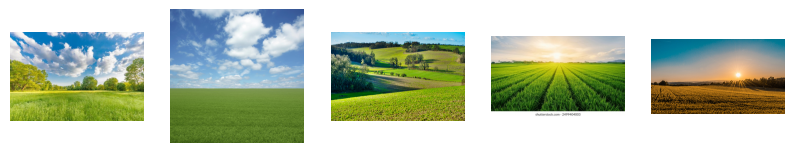

In [7]:
import os
from PIL import Image
import matplotlib.pyplot as plt

def display_sample_images(directory, num_images=5):
    image_files = [f for f in os.listdir(directory) if f.endswith(('jpg', 'png'))]
    
    plt.figure(figsize=(10, 5))
    for i, img_file in enumerate(image_files[:num_images]):
        img_path = os.path.join(directory, img_file)
        img = Image.open(img_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

directory = 'background'
display_sample_images(directory)

### 1.3. Create dataset

In [13]:
!pip install opencv-python-headless

   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   --- ------------------------------------ 3.7/38.8 MB 19.8 MB/s eta 0:00:02
   ------- -------------------------------- 7.6/38.8 MB 18.8 MB/s eta 0:00:02
   ------------ --------------------------- 11.8/38.8 MB 18.9 MB/s eta 0:00:02
   ---------------- ----------------------- 16.3/38.8 MB 19.3 MB/s eta 0:00:02
   -------------------- ------------------- 19.7/38.8 MB 18.5 MB/s eta 0:00:02
   ------------------------ --------------- 23.9/38.8 MB 18.6 MB/s eta 0:00:01
   ----------------------------- ---------- 28.3/38.8 MB 19.1 MB/s eta 0:00:01
   ---------------------------------- ----- 33.0/38.8 MB 19.4 MB/s eta 0:00:01
   -------------------------------------- - 37.0/38.8 MB 19.4 MB/s eta 0:00:01
   ---------------------------------------  38.5/38.8 MB 19.4 MB/s eta 0:00:01
   ---------------------------------------- 38.8/38.8 MB 18.0 MB/s eta 0:00:00


### Dataset Creation

This is a crucial part of the assignment evaluation. From the selected objects and collected background images, follow these steps to generate your dataset:

1. **Randomly select background images** from your collection.
2. **Insert a single object** (from the three selected) into each background image at a **random location**.
3. **Record the object's coordinates** and create a corresponding bounding box. For example:
   - If an object with height `h` and width `w` is placed at position `(x, y)`, the bounding box should be in one of the following formats:
     - **[x, y, w, h]** or
     - **[x1, y1, x2, y2]**, where `x2 = x1 + w` and `y2 = y1 + h`.
4. If you plan to compare your custom model with a YOLO model, use the **YOLO bounding box format**:
   - `[(x + w/2)/image_width, (y + h/2)/image_height, w/image_width, h/image_height]`, where `image` refers to the background image dimensions.
5. **Save the generated dataset**, as it will be used for training your custom model and fine-tuning the existing object detection model.
6. **Wrap the dataset creation** in a **PyTorch Dataset class** for easier data handling and model training.
7. **Split the dataset** into training, validation, and test sets to evaluate your model effectively.


In [43]:
import cv2
import os

object_images = {
    'car': 'objects/car.png',
    'person': 'objects/person.png',
    'dog': 'objects/dog.png'
}

for obj_name, img_path in object_images.items():
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    if img is None:
        print(f"Error loading object image: {img_path}")
    else:
        print(f"Successfully loaded {img_path}")


Successfully loaded objects/car.png
Successfully loaded objects/person.png
Successfully loaded objects/dog.png


In [ ]:
import os
import random
import cv2

def createDataset(root_dir, dataset_name, split, img_size, num_images):
    split_dir = os.path.join(root_dir, dataset_name, split)
    os.makedirs(os.path.join(split_dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(split_dir, 'labels'), exist_ok=True)
    
    background_images = [os.path.join('background', f) for f in os.listdir('background') if f.endswith(('jpg', 'png'))]

    object_images = {
        'car': 'objects/car.png',
        'person': 'objects/person.png',
        'dog': 'objects/dog.png'
    }

    for i in range(num_images):
        bg_img_path = random.choice(background_images)
        bg_img = cv2.imread(bg_img_path)
        bg_img = cv2.resize(bg_img, img_size)
        
        obj_name = random.choice(list(object_images.keys()))
        obj_img_path = object_images[obj_name]
        obj_img = cv2.imread(obj_img_path, cv2.IMREAD_UNCHANGED)
        
        obj_h, obj_w = random.randint(50, 150), random.randint(50, 150)
        obj_img = cv2.resize(obj_img, (obj_w, obj_h))
        
        bg_h, bg_w = bg_img.shape[:2]
        x = random.randint(0, bg_w - obj_w)
        y = random.randint(0, bg_h - obj_h)

        for c in range(3):
            bg_img[y:y+obj_h, x:x+obj_w, c] = obj_img[:, :, c] * (obj_img[:, :, 3] / 255.0) + bg_img[y:y+obj_h, x:x+obj_w, c] * (1.0 - obj_img[:, :, 3] / 255.0)

        img_filename = f"{i:05d}.jpg"
        cv2.imwrite(os.path.join(split_dir, 'images', img_filename), bg_img)
        
        x_center = (x + obj_w / 2) / bg_w
        y_center = (y + obj_h / 2) / bg_h
        bbox_width = obj_w / bg_w
        bbox_height = obj_h / bg_h

        label_filename = f"{i:05d}.txt"
        with open(os.path.join(split_dir, 'labels', label_filename), 'w') as f:
            class_id = list(object_images.keys()).index(obj_name)
            f.write(f"{class_id} {x_center} {y_center} {bbox_width} {bbox_height}\n")

createDataset('dataset', 'background', split='train', img_size=(640, 640), num_images=3000)
createDataset('dataset', 'background', split='val', img_size=(640, 640), num_images=1000)
createDataset('dataset', 'background', split='test', img_size=(640, 640), num_images=200)


In [3]:
import os

image_dir = 'C:/Users/Marti/Desktop/MSC/DND/Vol.2/dataset/background/train/images'
label_dir = 'C:/Users/Marti/Desktop/MSC/DND/Vol.2/dataset/background/train/labels'

for i in range(1500, 3000):
    image_path = os.path.join(image_dir, f'{i:05d}.jpg')
    label_path = os.path.join(label_dir, f'{i:05d}.txt')
    
    if os.path.exists(image_path):
        os.remove(image_path)
        print(f'Deleted {image_path}')
    
    if os.path.exists(label_path):
        os.remove(label_path)
        print(f'Deleted {label_path}')


Deleted C:/Users/Marti/Desktop/MSC/DND/Vol.2/dataset/background/train/images\01500.jpg
Deleted C:/Users/Marti/Desktop/MSC/DND/Vol.2/dataset/background/train/labels\01500.txt
Deleted C:/Users/Marti/Desktop/MSC/DND/Vol.2/dataset/background/train/images\01501.jpg
Deleted C:/Users/Marti/Desktop/MSC/DND/Vol.2/dataset/background/train/labels\01501.txt
Deleted C:/Users/Marti/Desktop/MSC/DND/Vol.2/dataset/background/train/images\01502.jpg
Deleted C:/Users/Marti/Desktop/MSC/DND/Vol.2/dataset/background/train/labels\01502.txt
Deleted C:/Users/Marti/Desktop/MSC/DND/Vol.2/dataset/background/train/images\01503.jpg
Deleted C:/Users/Marti/Desktop/MSC/DND/Vol.2/dataset/background/train/labels\01503.txt
Deleted C:/Users/Marti/Desktop/MSC/DND/Vol.2/dataset/background/train/images\01504.jpg
Deleted C:/Users/Marti/Desktop/MSC/DND/Vol.2/dataset/background/train/labels\01504.txt
Deleted C:/Users/Marti/Desktop/MSC/DND/Vol.2/dataset/background/train/images\01505.jpg
Deleted C:/Users/Marti/Desktop/MSC/DND/Vol.

In [4]:
import torch
import yaml
from torch.utils.data import Dataset, DataLoader, Subset
import os
from PIL import Image
import torchvision.transforms as transforms
import numpy as np

class ObjectDetectionDataset(Dataset):
    def __init__(self, root_dir, num_classes=3, transform=None):
        self.image_dir = root_dir
        self.label_dir = root_dir.replace('images', 'labels')
        
        self.image_filenames = sorted(os.listdir(self.image_dir))
        self.transform = transform
        self.num_classes = num_classes

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        image = Image.open(img_path).convert("RGB")
        
        label_path = os.path.join(self.label_dir, self.image_filenames[idx].replace('.jpg', '.txt'))
        with open(label_path, 'r') as f:
            label = f.readline().split()
            class_id = int(label[0])
            bbox = [float(x) for x in label[1:]]

        if self.transform:
            image = self.transform(image)

        bbox = torch.tensor(bbox)

        return image, torch.tensor(class_id), bbox

with open('dataset/data.yaml', 'r') as f:
    data_config = yaml.safe_load(f)
    
train_path = data_config['train']
val_path = data_config['val']
test_path = data_config['test']

transform = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor(),
])

train_dataset = ObjectDetectionDataset(root_dir=train_path, transform=transform)
val_dataset = ObjectDetectionDataset(root_dir=val_path, transform=transform)
test_dataset = ObjectDetectionDataset(root_dir=test_path, transform=transform)

num_train_samples = 1500  
num_val_samples = 1000   

num_train_samples = min(num_train_samples, len(train_dataset))
num_val_samples = min(num_val_samples, len(val_dataset))

train_indices = np.random.choice(len(train_dataset), num_train_samples, replace=False)
val_indices = np.random.choice(len(val_dataset), num_val_samples, replace=False)

train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(val_dataset, val_indices)

train_loader = DataLoader(train_subset, batch_size=8, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=8, shuffle=False, num_workers=0, pin_memory=True)

test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0, pin_memory=True)


In [5]:
root_dir = 'C:/Users/Marti/Desktop/MSC/DND/Vol.2/dataset/background'
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = ObjectDetectionDataset(root_dir=os.path.join(root_dir, 'train', 'images'), transform=transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0, pin_memory=True)

val_dataset = ObjectDetectionDataset(root_dir=os.path.join(root_dir, 'val', 'images'), transform=transform)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0, pin_memory=True)

test_dataset = ObjectDetectionDataset(root_dir=os.path.join(root_dir, 'test', 'images'), transform=transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0, pin_memory=True)


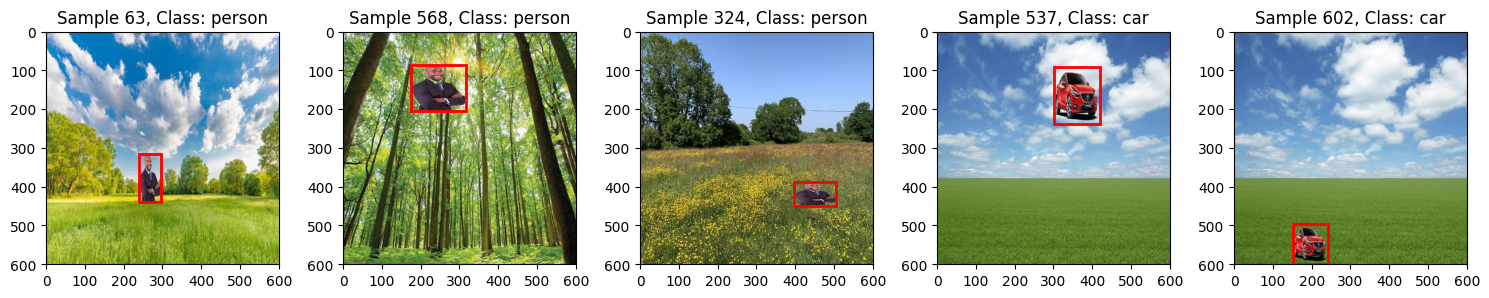

In [6]:
import matplotlib.pyplot as plt
import torchvision.transforms as T
import numpy as np

class_names = ['car', 'person', 'dog']

def visualize_dataset_grid(dataset, num_samples=5, num_cols=5):
    num_rows = num_samples // num_cols if num_samples % num_cols == 0 else (num_samples // num_cols) + 1

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5))
    axes = axes.flatten()
    
    random_indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    for i, idx in enumerate(random_indices):  
        image, class_id, bbox = dataset[idx] 
        image = image.permute(1, 2, 0).numpy() 
        
        image = np.clip(image, 0, 1)
        
        ax = axes[i]
        ax.imshow(image)
        
        h, w, _ = image.shape
        x_center, y_center, box_w, box_h = bbox.numpy()
        x1 = int((x_center - box_w / 2) * w)
        y1 = int((y_center - box_h / 2) * h)
        x2 = int((x_center + box_w / 2) * w)
        y2 = int((y_center + box_h / 2) * h)
        
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        
        ax.set_title(f"Sample {idx}, Class: {class_names[class_id]}")
        
        ax.set_xticks(np.arange(0, 601, 100))
        ax.set_yticks(np.arange(0, 601, 100))
        ax.set_xlim([0, 600])
        ax.set_ylim([600, 0])
        
    for j in range(i+1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_dataset_grid(train_dataset, num_samples=5, num_cols=5)


### 2. MODELS

In this assignment, you are tasked with building your own custom object detection model and comparing its performance against an existing object detection model.


### 2.1. Custom Object Detection model

### Create a Convolutional Neural Network (CNN) Architecture

Design a CNN-based architecture that includes a **backbone for feature extraction** and two output branches:

- One for **class probabilities** (with output size equal to the number of object classes, e.g., 3).
- Another for **bounding box regression** (with size 4 for the box coordinates: x, y, w, h, or in your chosen format).

This is the core evaluation of the assignment. Experiment with different layers, hyperparameters, and regularization techniques to optimize the model's performance.


In [44]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [45]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

class CustomModel(nn.Module):
    def __init__(self, num_classes=3):
        super(CustomModel, self).__init__()
        
        self.backbone = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.fc = nn.Linear(256 * 40 * 40, 512)
        
        self.classifier = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
        
        self.bbox_regressor = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 4)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = x.view(x.size(0), -1)
        
        x = self.fc(x)
        
        class_probs = self.classifier(x)
        bbox_regression = self.bbox_regressor(x)
        
        return class_probs, bbox_regression


In [46]:
dummy_image = torch.randn(1, 3, 640, 640).to(device)
num_classes = 3

model = CustomModel(num_classes).to(device)
cls_output, bbox_output = model(dummy_image)

print("Class Output Shape:", cls_output.shape)
print("Bounding Box Output Shape:", bbox_output.shape)


Class Output Shape: torch.Size([1, 3])
Bounding Box Output Shape: torch.Size([1, 4])


### 2.2. Train Your Model

Carefully choose key components like the **optimizer**, **loss function**, **number of epochs**, and **regularization techniques**. Ensure you're optimizing both **classification loss** and **bounding box regression loss**.

Monitor for signs of **overfitting** or **underfitting** by tracking how the loss evolves across epochs. The loss should consistently decrease as training progresses. Save and log these losses for visualization and further analysis.


**Example Plot**:

<a href="https://ibb.co/bzmMxJY"><img src="https://i.ibb.co/t8KTSXn/download.png" alt="download" border="0"></a>

Epoch [1/10], Train Loss: 1.2484, Val Loss: 1.1268
Epoch [2/10], Train Loss: 1.1167, Val Loss: 1.1149
Epoch [3/10], Train Loss: 1.1147, Val Loss: 1.1143
Epoch [4/10], Train Loss: 1.1148, Val Loss: 1.1144
Epoch [5/10], Train Loss: 1.1147, Val Loss: 1.1142
Epoch [6/10], Train Loss: 1.1145, Val Loss: 1.1143
Epoch [7/10], Train Loss: 1.1145, Val Loss: 1.1143
Epoch [8/10], Train Loss: 1.1143, Val Loss: 1.1145
Epoch [9/10], Train Loss: 1.1146, Val Loss: 1.1142
Epoch [10/10], Train Loss: 1.1145, Val Loss: 1.1146
Model saved successfully!


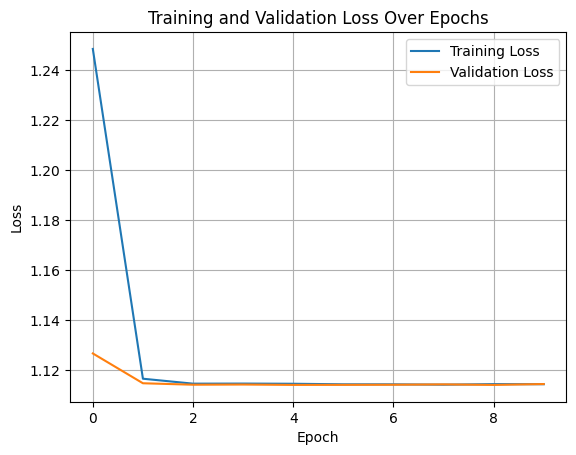

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

class_loss_fn = nn.CrossEntropyLoss()
bbox_loss_fn = nn.SmoothL1Loss()

class_loss_weight = 1.0 
bbox_loss_weight = 1.0

def train_model(model, train_loader, val_loader, optimizer, class_loss_fn, bbox_loss_fn, num_epochs=10):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, class_ids, bboxes in train_loader:
            images, class_ids, bboxes = images.to(device), class_ids.to(device), bboxes.to(device)

            optimizer.zero_grad()

            class_probs, bbox_preds = model(images)

            loss_class = class_loss_fn(class_probs, class_ids)
            loss_bbox = bbox_loss_fn(bbox_preds, bboxes)

            loss = class_loss_weight * loss_class + bbox_loss_weight * loss_bbox

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()  
        val_running_loss = 0.0

        with torch.no_grad():
            for images, class_ids, bboxes in val_loader:
                images, class_ids, bboxes = images.to(device), class_ids.to(device), bboxes.to(device)

                class_probs, bbox_preds = model(images)

                val_loss_class = class_loss_fn(class_probs, class_ids)
                val_loss_bbox = bbox_loss_fn(bbox_preds, bboxes)
                val_loss = val_loss_class + val_loss_bbox

                val_running_loss += val_loss.item()

        val_loss = val_running_loss / len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    torch.save(model.state_dict(), 'best_model.pth')
    print("Model saved successfully!")

    return train_losses, val_losses

def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss Over Epochs')
    plt.grid(True)
    plt.show()

num_epochs = 10

train_losses, val_losses = train_model(model, train_loader, val_loader, optimizer, class_loss_fn, bbox_loss_fn, num_epochs)

plot_losses(train_losses, val_losses)


### 2.3. Evaulate and do inference with the trained custom model

Choose **at least 3 metrics** to evaluate your object detection model. These could include:

- **Precision**: The proportion of correctly predicted positive instances (objects detected) out of all instances classified as positive.
- **Recall**: The proportion of correctly predicted positive instances out of all actual positive instances (objects present in the image).
- **F1-Score**: The harmonic mean of Precision and Recall, balancing false positives and false negatives.
- **IoU (Intersection over Union)**: Measures the overlap between the predicted bounding box and the ground truth bounding box.
- **mAP (mean Average Precision)**: This is one of the most common evaluation metrics for object detection. It averages precision at different recall thresholds across all object classes.
  
Additionally, you can assess:
- **Inference speed**: Time taken by the model to process a single image.
- **Number of parameters**: The total number of trainable parameters in the model.
- **Model size**: The disk size of the trained model.

### Show Performance Metric Visualizations

- Visualize the chosen metrics (e.g., **Precision, Recall, F1-Score, IoU, mAP**) over different epochs to demonstrate the improvement in the model’s performance.
- Plot losses (both classification loss and localization loss) to show how they decrease throughout training.

### Show Some Predictions of Your Trained Model

- Display sample images with **predicted bounding boxes** and compare them to the ground truth.
- Highlight the values of **Precision, Recall, IoU**, or other relevant metrics for each displayed prediction, giving a clear view of the model's performance.
  
You can also use **WandB (Weights and Biases)** or **TensorBoard** for more detailed logging and tracking of these metrics and visualizations.


In [24]:
model = CustomModel(num_classes=3).to(device)
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

def calculate_metrics(model, test_loader, device, num_classes=3, iou_threshold=0.5):
    model.eval()
    all_true_boxes = []
    all_pred_boxes = []
    all_scores = []
    all_class_ids = []
    precisions, recalls, aps = [], [], []

    with torch.no_grad():
        for images, class_ids, true_bboxes in test_loader:
            images = images.to(device)
            
            class_probs, bbox_preds = model(images)
            
            for i in range(len(images)):
                true_bbox = true_bboxes[i].cpu().numpy()
                pred_bbox = bbox_preds[i].cpu().numpy()
                class_id = class_ids[i].cpu().numpy()

                pred_class = torch.argmax(class_probs[i]).item()
                pred_score = torch.max(class_probs[i]).item()

                all_true_boxes.append(true_bbox)
                all_pred_boxes.append(pred_bbox)
                all_scores.append(pred_score)
                all_class_ids.append(pred_class)

    for class_id in range(num_classes):
        true_boxes_class = [box for i, box in enumerate(all_true_boxes) if all_class_ids[i] == class_id]
        pred_boxes_class = [box for i, box in enumerate(all_pred_boxes) if all_class_ids[i] == class_id]
        pred_scores_class = [score for i, score in enumerate(all_scores) if all_class_ids[i] == class_id]

        if len(pred_boxes_class) == 0:
            precisions.append(0)
            recalls.append(0)
            aps.append(0)
            continue
        
        precision, recall, _ = precision_recall_curve([1] * len(pred_boxes_class), pred_scores_class)
        average_precision = average_precision_score([1] * len(pred_boxes_class), pred_scores_class)
        
        precisions.append(precision.mean())
        recalls.append(recall.mean())
        aps.append(average_precision)

    mean_ap = np.mean(aps)
    
    print(f"mAP: {mean_ap:.4f}")
    print(f"Precision: {np.mean(precisions):.4f}, Recall: {np.mean(recalls):.4f}")
    
    return np.mean(precisions), np.mean(recalls), mean_ap

precision, recall, mean_ap = calculate_metrics(model, test_loader, device)

C:\Users\Marti\AppData\Local\Temp\ipykernel_11304\3338862836.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


mAP: 0.3333
Precision: 0.3333, Recall: 0.1646


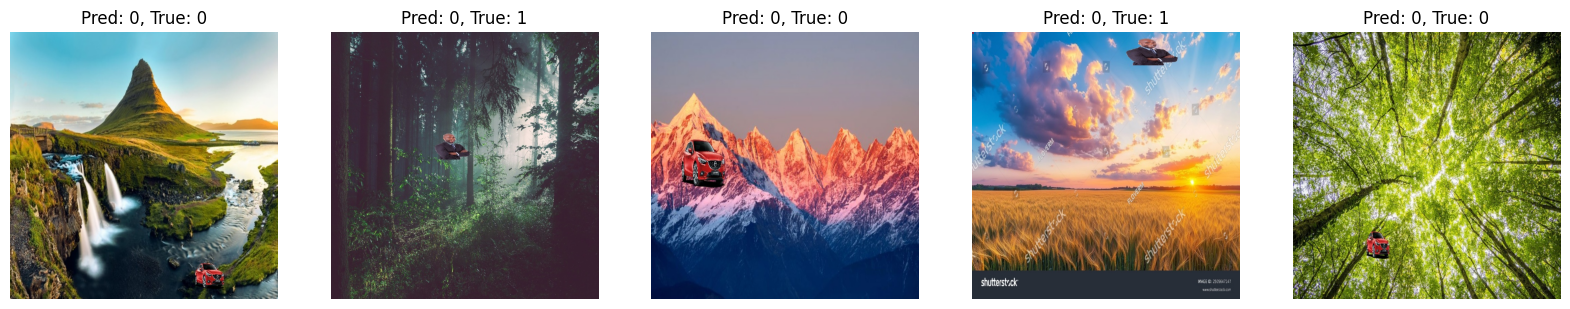

Number of trainable parameters: 210236359
Model size: 801.99 MB
Average inference time per image: 0.4081 seconds


In [25]:
import time
def visualize_predictions(model, test_dataset, device, num_samples=5):
    model.eval()
    
    fig, ax = plt.subplots(1, num_samples, figsize=(20, 5))
    
    for i in range(num_samples):
        image, class_id, target_bbox = test_dataset[i]
        image = image.unsqueeze(0).to(device)
        
        with torch.no_grad():
            class_pred, bbox_pred = model(image)
        
        image = image.squeeze(0).cpu().permute(1, 2, 0)
        bbox_pred = bbox_pred.cpu().squeeze(0)
        target_bbox = target_bbox.cpu()
        
        ax[i].imshow(image)
        
        rect_pred = plt.Rectangle((bbox_pred[0], bbox_pred[1]), bbox_pred[2], bbox_pred[3], 
                                  fill=False, color='r', linewidth=2)
        ax[i].add_patch(rect_pred)
        
        rect_true = plt.Rectangle((target_bbox[0], target_bbox[1]), target_bbox[2], target_bbox[3], 
                                  fill=False, color='g', linewidth=2)
        ax[i].add_patch(rect_true)
        
        ax[i].set_title(f"Pred: {torch.argmax(class_pred).item()}, True: {class_id.item()}")
        ax[i].axis('off')
    
    plt.show()

visualize_predictions(model, test_dataset, device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_size = os.path.getsize('best_model.pth') / (1024 * 1024)

print(f"Number of trainable parameters: {num_params}")
print(f"Model size: {model_size:.2f} MB")

def measure_inference_time(model, test_loader, device):
    model.eval()
    start_time = time.time()
    
    with torch.no_grad():
        for images, _, _ in test_loader:
            images = images.to(device)
            model(images)
    
    end_time = time.time()
    avg_time_per_image = (end_time - start_time) / len(test_loader.dataset)
    print(f"Average inference time per image: {avg_time_per_image:.4f} seconds")

measure_inference_time(model, test_loader, device)

### 2.4. Load an Existing Object Detection Model

We recommend using the latest **YOLO** version, but you are free to choose any other **PyTorch-based** object detection model.


In [28]:
!pip install --user ultralytics

In [51]:
from ultralytics import YOLO
Yo_model = YOLO('yolov8n.pt')

### 2.5. Fine-tune the existing object detection model
If you choose to use **YOLO**, training the model can be done easily by providing a `data.yaml` file (which follows a specific format, check the official GitHub repository for details) and running the training script.

For example, you can run YOLO from the command line with:

```bash
!yolo task=detect mode=train data=datasets/data.yaml model=yolov8n.yaml epochs=200 imgsz=640
```

Make sure to show the losses and metrics visualizations. By default, YOLO should **verbose** those.

In [30]:
!yolo task=detect mode=train data=dataset/data.yaml model=yolov8n.pt epochs=10 imgsz=640 project=runs/detect name=train verbose=True

New https://pypi.org/project/ultralytics/8.3.21 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.15 🚀 Python-3.12.6 torch-2.4.1+cpu CPU (Intel Core(TM) i5-8250U 1.60GHz)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=dataset/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=runs/detect, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fr


train: Scanning C:\Users\Marti\Desktop\MSC\DND\Vol.2\dataset\background\train\labels...:   0%|          | 0/1500 [00:00<?, ?it/s]
train: Scanning C:\Users\Marti\Desktop\MSC\DND\Vol.2\dataset\background\train\labels... 48 images, 0 backgrounds, 0 corrupt:   3%|▎         | 48/1500 [00:00<00:03, 479.46it/s]
train: Scanning C:\Users\Marti\Desktop\MSC\DND\Vol.2\dataset\background\train\labels... 159 images, 0 backgrounds, 0 corrupt:  11%|█         | 159/1500 [00:00<00:01, 839.52it/s]
train: Scanning C:\Users\Marti\Desktop\MSC\DND\Vol.2\dataset\background\train\labels... 263 images, 0 backgrounds, 0 corrupt:  18%|█▊        | 263/1500 [00:00<00:01, 903.96it/s]
train: Scanning C:\Users\Marti\Desktop\MSC\DND\Vol.2\dataset\background\train\labels... 360 images, 0 backgrounds, 0 corrupt:  24%|██▍       | 360/1500 [00:00<00:01, 901.30it/s]
train: Scanning C:\Users\Marti\Desktop\MSC\DND\Vol.2\dataset\background\train\labels... 450 images, 0 backgrounds, 0 corrupt:  30%|███       | 450/1500 [00:00<

### 2.6 Evaluate the existing object detection model
**Compare the performance** of your custom model and the YOLO model, ensuring both are evaluated on the **same subset of images** using the **same metrics** chosen in **Step 2.3** (e.g., Precision, Recall, F1-Score, IoU, mAP).


In [53]:
Yo_model = YOLO('runs/detect/train/weights/last.pt')
results = Yo_model.predict(source=R'C:\Users\Marti\Desktop\MSC\DND\Vol.2\dataset\background\train\images', save=True, max_det=1)



WARNING  inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/1500 C:\Users\Marti\Desktop\MSC\DND\Vol.2\dataset\background\train\images\00000.jpg: 640x640 1 dog, 181.1ms
image 2/1500 C:\Users\Marti\Desktop\MSC\DND\Vol.2\dataset\background\train\images\00001.jpg: 640x640 1 car, 192.7ms
image 3/1500 C:\Users\Marti\Desktop\MSC\DND\Vol.2\dataset\background\train\images\00002.jpg: 640x640 1 car, 140.5ms
image 4/1500 C:\Users\Marti\Desktop\MSC\DND\Vol.2\dataset\background\train\images\00003.jpg: 640x640 1 person,

In [ ]:
import numpy as np
import os
from sklearn.metrics import precision_score, recall_score, f1_score

all_pred_class_ids_yolo = []
all_pred_boxes_yolo = []

for result in results:
    if result.boxes.cls.size(0) > 0:
        top_pred_class_id = result.boxes.cls[0].cpu().numpy()
        top_pred_box = result.boxes.xywh[0].cpu().numpy()
        all_pred_class_ids_yolo.append(top_pred_class_id)
        all_pred_boxes_yolo.append(top_pred_box)

if len(all_pred_class_ids_yolo) > 0 and len(all_pred_boxes_yolo) > 0:
    flat_pred_class_ids = np.array(all_pred_class_ids_yolo)
    flat_pred_boxes = np.array(all_pred_boxes_yolo)
else:
    print("No valid predictions available to evaluate.")

def load_true_labels(label_folder, image_size=(640, 640)):
    label_files = sorted(os.listdir(label_folder))
    
    def parse_line(line):
        class_id, x_center, y_center, width, height = map(float, line.strip().split())
        x_min = (x_center - width / 2) * image_size[0]
        y_min = (y_center - height / 2) * image_size[1]
        x_max = (x_center + width / 2) * image_size[0]
        y_max = (y_center + height / 2) * image_size[1]
        return int(class_id), [x_min, y_min, x_max, y_max]
    
    true_labels = [
        parse_line(line)
        for label_file in label_files
        for line in open(os.path.join(label_folder, label_file)).readlines()
    ]
    
    true_class_ids, true_boxes = zip(*true_labels)
    return np.array(true_class_ids), np.array(true_boxes)

def compute_iou(boxes1, boxes2):
    x1_min = np.maximum(boxes1[:, 0], boxes2[:, 0])
    y1_min = np.maximum(boxes1[:, 1], boxes2[:, 1])
    x1_max = np.minimum(boxes1[:, 2], boxes2[:, 2])
    y1_max = np.minimum(boxes1[:, 3], boxes2[:, 3])

    inter_area = np.maximum(0, x1_max - x1_min) * np.maximum(0, y1_max - y1_min)
    area1 = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])
    area2 = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])
    union_area = area1 + area2 - inter_area + 1e-6
    return inter_area / union_area

def evaluate_yolo_model(true_class_ids, true_boxes, pred_class_ids, pred_boxes, iou_threshold=0.5):
    precision = precision_score(true_class_ids, pred_class_ids, average='weighted')
    recall = recall_score(true_class_ids, pred_class_ids, average='weighted')
    f1 = f1_score(true_class_ids, pred_class_ids, average='weighted')

    true_boxes_np = np.array(true_boxes)
    pred_boxes_np = np.array([convert_xywh_to_x1y1x2y2(box) for box in pred_boxes])
    ious = compute_iou(true_boxes_np, pred_boxes_np)

    matches = ious >= iou_threshold
    class_matches = np.array(true_class_ids) == np.array(pred_class_ids)

    true_positive = np.sum(matches & class_matches)
    false_positive = np.sum(~matches & class_matches)
    false_negative = np.sum(matches & ~class_matches)

    object_detection_precision = true_positive / (true_positive + false_positive) if true_positive + false_positive > 0 else 0
    object_detection_recall = true_positive / (true_positive + false_negative) if true_positive + false_negative > 0 else 0
    object_detection_f1 = 2 * (object_detection_precision * object_detection_recall) / (object_detection_precision + object_detection_recall) if object_detection_precision + object_detection_recall > 0 else 0
    mAP = np.mean(ious)

    print(f'Classification Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}')
    print(f'Object Detection Precision (IoU>{iou_threshold}): {object_detection_precision:.4f}, Recall: {object_detection_recall:.4f}, F1-Score: {object_detection_f1:.4f}, mAP: {mAP:.4f}')

    return precision, recall, f1, object_detection_precision, object_detection_recall, object_detection_f1, mAP

label_folder = r'C:\Users\Marti\Desktop\MSC\DND\Vol.2\dataset\background\test\labels'
true_class_ids, true_boxes = load_true_labels(label_folder)

num_samples_to_evaluate = min(len(true_class_ids), len(flat_pred_class_ids))
evaluate_yolo_model(
    true_class_ids[:num_samples_to_evaluate], 
    true_boxes[:num_samples_to_evaluate], 
    flat_pred_class_ids[:num_samples_to_evaluate], 
    flat_pred_boxes[:num_samples_to_evaluate]
)


Classification Precision: 0.3297, Recall: 0.3250, F1-Score: 0.3255
Object Detection Precision (IoU>0.5): 0.0000, Recall: 0.0000, F1-Score: 0.0000, mAP: 0.0000


(0.32965658295281586, 0.325, 0.32547619047619053, 0.0, 0, 0, 0.0)

# 3. COMPARISON
**Compare the performance** of your custom model and the YOLO model, ensuring both are evaluated on the **same subset of images** for a fair comparison. Key metrics to include:

- **Precision**
- **Recall**
- **F1-Score**
- **IoU (Intersection over Union)**
- **mAP (mean Average Precision)**

### Visualize Predictions

- Show predictions from both models on the same images.
- Include bounding boxes, class labels, and relevant metrics like IoU or Precision.

### Explain Differences

- Discuss why one model may perform better than the other, considering architecture, dataset complexity, or fine-tuning.

### Improve Custom Model

- Suggest improvements such as better data augmentation, model architecture adjustments, hyperparameter tuning, or more training data.
- Explore **Transfer Learning**, **learning rate scheduling**, or new optimizers for better performance.



image 1/1 C:\Users\Marti\Desktop\MSC\DND\Vol.2\dataset\background\test\images\00000.jpg: 640x640 1 car, 326.4ms
Speed: 44.0ms preprocess, 326.4ms inference, 20.4ms postprocess per image at shape (1, 3, 640, 640)


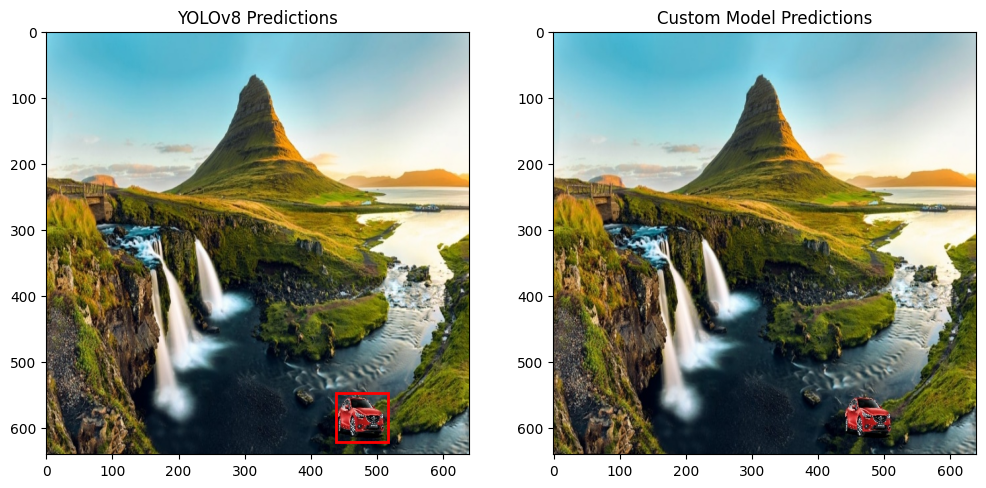


image 1/1 C:\Users\Marti\Desktop\MSC\DND\Vol.2\dataset\background\test\images\00001.jpg: 640x640 1 person, 249.5ms
Speed: 11.4ms preprocess, 249.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


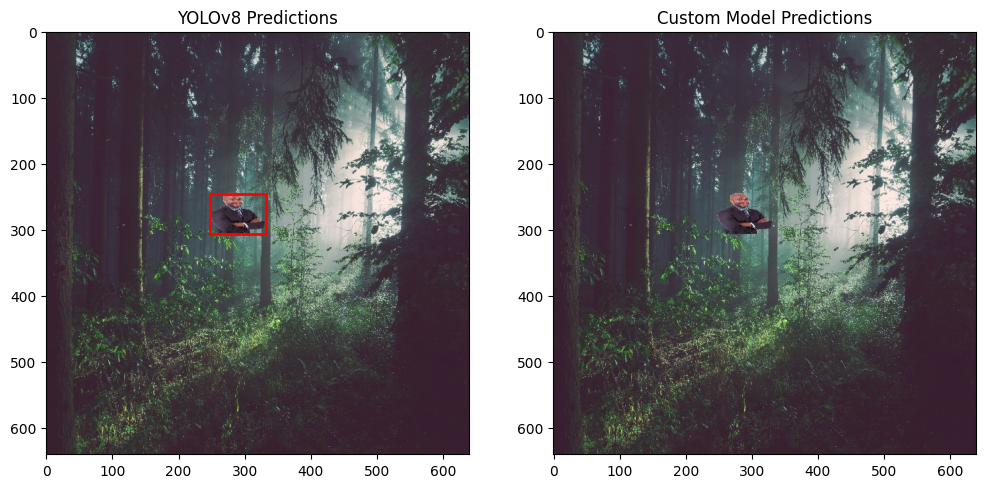


image 1/1 C:\Users\Marti\Desktop\MSC\DND\Vol.2\dataset\background\test\images\00002.jpg: 640x640 1 car, 200.9ms
Speed: 7.4ms preprocess, 200.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


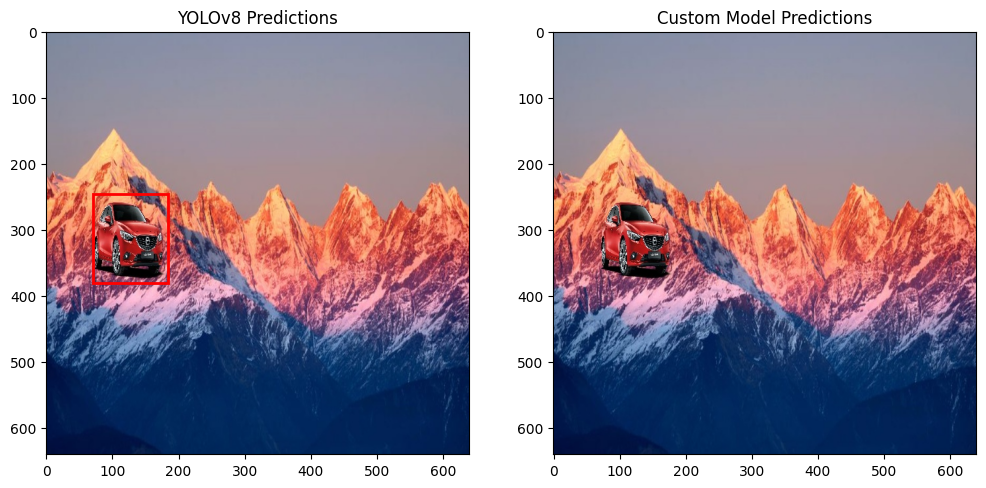


image 1/1 C:\Users\Marti\Desktop\MSC\DND\Vol.2\dataset\background\test\images\00003.jpg: 640x640 1 person, 306.6ms
Speed: 8.3ms preprocess, 306.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


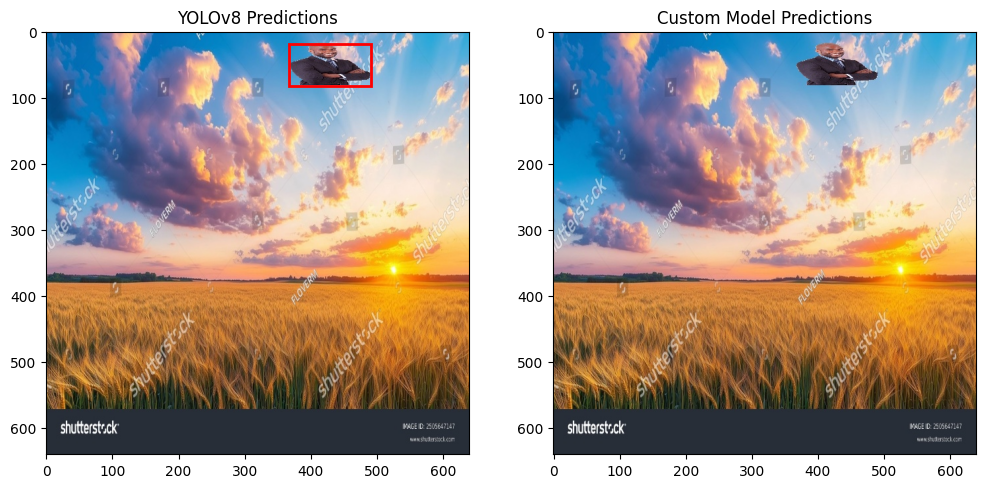


image 1/1 C:\Users\Marti\Desktop\MSC\DND\Vol.2\dataset\background\test\images\00004.jpg: 640x640 1 car, 262.7ms
Speed: 5.8ms preprocess, 262.7ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)


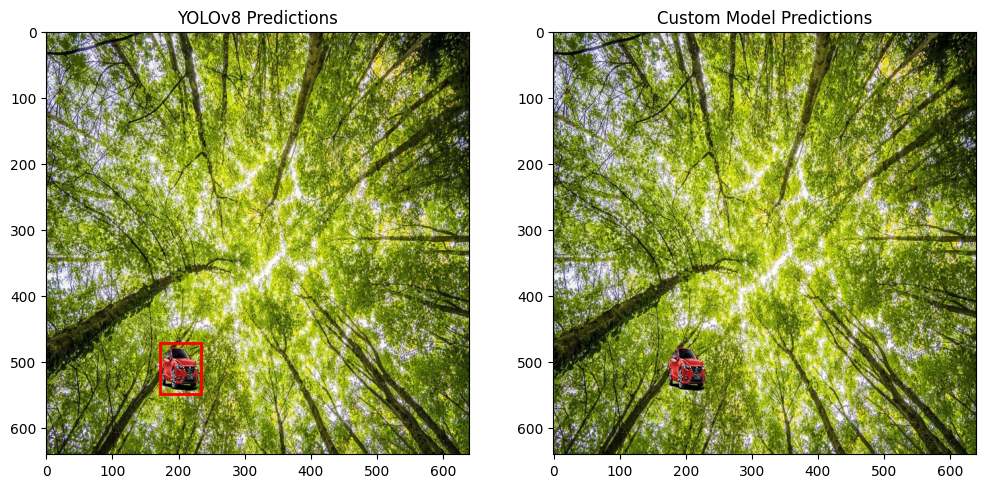

In [55]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

num_classes = 3
custom_model = CustomModel(num_classes=num_classes)
custom_model.load_state_dict(torch.load('best_model.pth'))
custom_model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
custom_model = custom_model.to(device)
yolo_model = YOLO('runs/detect/train/weights/last.pt')

test_images_dir = r'C:\Users\Marti\Desktop\MSC\DND\Vol.2\dataset\background\test\images'
test_labels_dir = r'C:\Users\Marti\Desktop\MSC\DND\Vol.2\dataset\background\test\labels'

def yolo_inference(image_path):
    results = yolo_model(image_path)
    return results

def custom_inference(image_path, model):
    image = cv2.imread(image_path)
    image_tensor = transforms.ToTensor()(image).unsqueeze(0)
    image_tensor = image_tensor.to(device)
    
    with torch.no_grad():
        class_output, bbox_output = model(image_tensor)
    
    return bbox_output.cpu().numpy()

def visualize_predictions(image_path, yolo_results, custom_results, labels):
    image = cv2.imread(image_path)
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    for result in yolo_results[0].boxes.xyxy:
        x1, y1, x2, y2 = result[:4]
        ax[0].add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, color='r', fill=False, linewidth=2))
    ax[0].set_title("YOLOv8 Predictions")

    ax[1].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    for box in custom_results:
        x1, y1, x2, y2 = box  
        ax[1].add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, color='b', fill=False, linewidth=2))
    ax[1].set_title("Custom Model Predictions")
    
    plt.show()

def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    
    iou = interArea / float(boxAArea + boxBArea - interArea + 1e-6)
    return iou

def compare_models(yolo_model, custom_model, test_images_dir, test_labels_dir):
    visualization_limit = 5
    count = 0

    for image_name in os.listdir(test_images_dir):
        if count >= visualization_limit:
            break

        image_path = os.path.join(test_images_dir, image_name)
        label_path = os.path.join(test_labels_dir, image_name.replace('.jpg', '.txt'))
        
        true_boxes = []
        with open(label_path) as f:
            for line in f.readlines():
                class_id, x_center, y_center, width, height = map(float, line.split())
                x1 = x_center - width / 2
                y1 = y_center - height / 2
                x2 = x_center + width / 2
                y2 = y_center + height / 2
                true_boxes.append([x1, y1, x2, y2])

        yolo_results = yolo_inference(image_path)
        custom_results = custom_inference(image_path, custom_model)
        visualize_predictions(image_path, yolo_results, custom_results, true_boxes)
        count += 1

compare_models(yolo_model, custom_model, test_images_dir, test_labels_dir)


**Differences**

Architecture: Custom model has simpler architectures compared to established model like YOLO, which is optimized for rapid and accurate detection across diverse scenarios. YOLO includes advanced layers to handle various object sizes.

Dataset Complexity: Custom model is trained on a smaller dataset, it may struggle. YOLO, pre-trained on diverse datasets, adapts better.

Fine-tuning: YOLO benefits from extensive fine-tuning and transfer learning, leveraging pre-trained weights. Custom models without transfer learning often have lower performance due to limited initial training.

**Improve Custom Model**

Data Augmentation: Apply transformations like rotation, flipping, and color changes to expand the training dataset and reduce overfitting.

Model Architecture: Consider adding convolutional layers or residual connections to improve feature extraction.

Hyperparameter Tuning: Experiment with batch size, learning rate, and regularization to enhance model performance.

Learning Rate Scheduling and Optimizers: Implement learning rate schedulers (e.g., ReduceLROnPlateau) and try optimizers like AdamW to stabilize training and improve performance.
